In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [4]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [15]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [6]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

W0415 13:55:44.239841 140535507363648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0415 13:55:44.248153 140535507363648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0415 13:55:44.249480 140535507363648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0415 13:55:44.257165 140535507363648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0415 13:55:44.291562 140535507363648 deprecation_wrapp

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [8]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [9]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

W0415 13:55:44.585012 140535507363648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0074 - val_loss: 0.0026

Epoch 00001: val_loss improved from inf to 0.00259, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0019 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00259 to 0.00187, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0014 - val_loss: 0.0018

Epoch 00003: val_loss improved from 0.00187 to 0.00183, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 0.0018

Epoch 00004: val_loss did not improve from 0.00183
Epoch 5/150
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00005: val_loss did not improve from 0.00183
Epoch 6/150
1712/1712 [==============================] - 3s 2ms/step - 

1712/1712 [==============================] - 3s 2ms/step - loss: 1.9289e-04 - val_loss: 7.6822e-04

Epoch 00047: val_loss did not improve from 0.00075
Epoch 48/150
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8655e-04 - val_loss: 7.7142e-04

Epoch 00048: val_loss did not improve from 0.00075
Epoch 49/150
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9411e-04 - val_loss: 7.7569e-04

Epoch 00049: val_loss did not improve from 0.00075
Epoch 50/150
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9325e-04 - val_loss: 7.4071e-04

Epoch 00050: val_loss improved from 0.00075 to 0.00074, saving model to best_weights.h5
Epoch 51/150
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8578e-04 - val_loss: 7.5806e-04

Epoch 00051: val_loss did not improve from 0.00074
Epoch 52/150
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7984e-04 - val_loss: 7.9490e-04

Epoch 00052: val_loss did not improve from 


Epoch 00096: val_loss did not improve from 0.00073
Epoch 97/150
1712/1712 [==============================] - 3s 2ms/step - loss: 1.2124e-04 - val_loss: 7.8429e-04

Epoch 00097: val_loss did not improve from 0.00073
Epoch 98/150
1712/1712 [==============================] - 3s 2ms/step - loss: 1.2087e-04 - val_loss: 7.5902e-04

Epoch 00098: val_loss did not improve from 0.00073
Epoch 99/150
1712/1712 [==============================] - 3s 2ms/step - loss: 1.1768e-04 - val_loss: 7.8950e-04

Epoch 00099: val_loss did not improve from 0.00073
Epoch 100/150
1712/1712 [==============================] - 3s 2ms/step - loss: 1.2096e-04 - val_loss: 7.8669e-04

Epoch 00100: val_loss did not improve from 0.00073
Epoch 101/150
1712/1712 [==============================] - 3s 2ms/step - loss: 1.1490e-04 - val_loss: 7.6235e-04

Epoch 00101: val_loss did not improve from 0.00073
Epoch 102/150
1712/1712 [==============================] - 3s 2ms/step - loss: 1.1297e-04 - val_loss: 7.3987e-04

Epoch 00102:

1712/1712 [==============================] - 3s 2ms/step - loss: 8.9328e-05 - val_loss: 7.5587e-04

Epoch 00146: val_loss did not improve from 0.00072
Epoch 147/150
1712/1712 [==============================] - 3s 2ms/step - loss: 8.7088e-05 - val_loss: 7.5929e-04

Epoch 00147: val_loss did not improve from 0.00072
Epoch 148/150
1712/1712 [==============================] - 3s 1ms/step - loss: 8.7535e-05 - val_loss: 7.9492e-04

Epoch 00148: val_loss did not improve from 0.00072
Epoch 149/150
1712/1712 [==============================] - 3s 1ms/step - loss: 8.4840e-05 - val_loss: 7.8182e-04

Epoch 00149: val_loss did not improve from 0.00072
Epoch 150/150
1712/1712 [==============================] - 3s 1ms/step - loss: 8.6420e-05 - val_loss: 7.6079e-04

Epoch 00150: val_loss did not improve from 0.00072


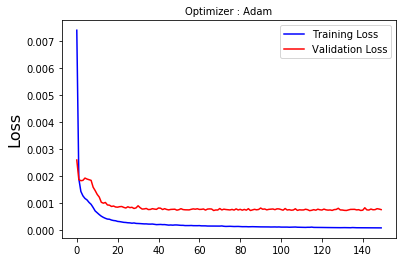

In [10]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [11]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [12]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

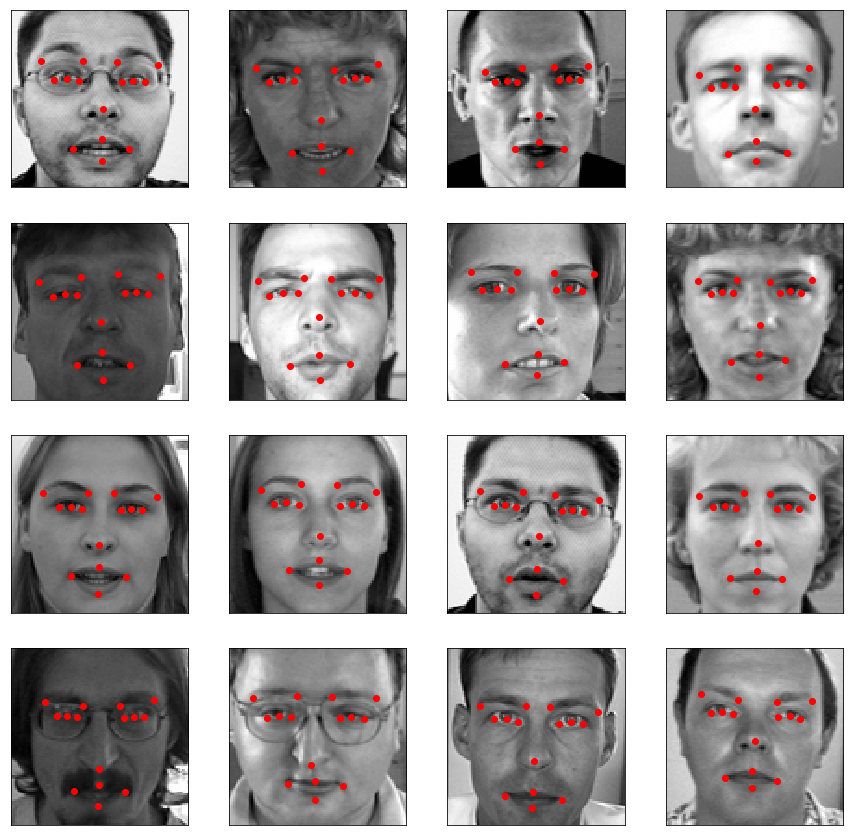

In [13]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

In [33]:
# image augmentation
import copy
def clip_image(image):
    return image[:,::-1]

def clip_points(points, weight = 96):
    # inverse normalize
    original_points = (points + 0.5)*weight
    new_points = (points + 0.5)*weight
    # clip
    clip_dict = {0:2,2:0,4:8,8:4,6:10,10:6,12:16,16:12,14:18,18:14,20:20,22:24,24:22,26:26,28:28}
    for i in list(clip_dict.keys()):
        new_points[i] = weight - original_points[clip_dict[i]]
    return new_points/weight - 0.5

imgs_train_clip = np.zeros(imgs_train.shape)
points_train_clip = np.zeros(points_train.shape)

for index in range(imgs_train_clip.shape[0]):
    imgs_train_clip[index] = clip_image(imgs_train[index])
    points_train_clip[index] = clip_points(points_train[index], weight = 96)

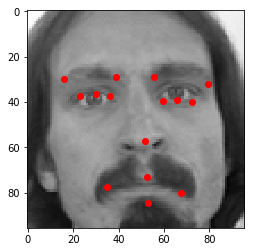

In [34]:
plot_keypoints(imgs_train_clip[0], np.squeeze(points_train_clip[0]))

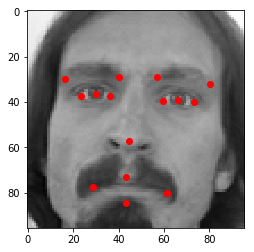

In [35]:
plot_keypoints(imgs_train[0], np.squeeze(points_train[0]))

In [46]:
total_imgs_train = np.vstack([imgs_train, imgs_train_clip])
total_points_train = np.vstack([points_train, points_train_clip])

new_model = get_model()
# 配置 loss funtion 和 optimizer
new_model.compile(loss='mean_squared_error', optimizer='adam')

# training the model
hist_model = new_model.fit(total_imgs_train.reshape(-1, 96, 96, 1), 
                       total_points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('new_weights.h5')
# save the model
model.save('new_model.h5')

Train on 3424 samples, validate on 856 samples
Epoch 1/150
3424/3424 [==============================] - 6s 2ms/step - loss: 0.0047 - val_loss: 0.0016

Epoch 00001: val_loss did not improve from 0.00072
Epoch 2/150
3424/3424 [==============================] - 5s 2ms/step - loss: 0.0014 - val_loss: 0.0017

Epoch 00002: val_loss did not improve from 0.00072
Epoch 3/150
3424/3424 [==============================] - 5s 2ms/step - loss: 0.0012 - val_loss: 0.0015

Epoch 00003: val_loss did not improve from 0.00072
Epoch 4/150
3424/3424 [==============================] - 5s 2ms/step - loss: 9.9474e-04 - val_loss: 0.0013

Epoch 00004: val_loss did not improve from 0.00072
Epoch 5/150
3424/3424 [==============================] - 5s 2ms/step - loss: 7.6977e-04 - val_loss: 0.0012

Epoch 00005: val_loss did not improve from 0.00072
Epoch 6/150
3424/3424 [==============================] - 5s 2ms/step - loss: 6.4748e-04 - val_loss: 0.0011

Epoch 00006: val_loss did not improve from 0.00072
Epoch 7/150

3424/3424 [==============================] - 5s 1ms/step - loss: 1.5660e-04 - val_loss: 8.9331e-04

Epoch 00051: val_loss did not improve from 0.00072
Epoch 52/150
3424/3424 [==============================] - 5s 2ms/step - loss: 1.6245e-04 - val_loss: 8.9909e-04

Epoch 00052: val_loss did not improve from 0.00072
Epoch 53/150
3424/3424 [==============================] - 5s 2ms/step - loss: 1.6090e-04 - val_loss: 8.6767e-04

Epoch 00053: val_loss did not improve from 0.00072
Epoch 54/150
3424/3424 [==============================] - 5s 2ms/step - loss: 1.5763e-04 - val_loss: 9.2138e-04

Epoch 00054: val_loss did not improve from 0.00072
Epoch 55/150
3424/3424 [==============================] - 5s 2ms/step - loss: 1.5817e-04 - val_loss: 9.8110e-04

Epoch 00055: val_loss did not improve from 0.00072
Epoch 56/150
3424/3424 [==============================] - 5s 2ms/step - loss: 1.5296e-04 - val_loss: 9.2230e-04

Epoch 00056: val_loss did not improve from 0.00072
Epoch 57/150
3424/3424 [=====

3424/3424 [==============================] - 5s 2ms/step - loss: 1.0377e-04 - val_loss: 8.8765e-04

Epoch 00101: val_loss did not improve from 0.00072
Epoch 102/150
3424/3424 [==============================] - 5s 2ms/step - loss: 1.0380e-04 - val_loss: 9.1716e-04

Epoch 00102: val_loss did not improve from 0.00072
Epoch 103/150
3424/3424 [==============================] - 5s 2ms/step - loss: 1.0488e-04 - val_loss: 9.0889e-04

Epoch 00103: val_loss did not improve from 0.00072
Epoch 104/150
3424/3424 [==============================] - 5s 2ms/step - loss: 1.0292e-04 - val_loss: 9.0090e-04

Epoch 00104: val_loss did not improve from 0.00072
Epoch 105/150
3424/3424 [==============================] - 5s 2ms/step - loss: 1.0325e-04 - val_loss: 9.3505e-04

Epoch 00105: val_loss did not improve from 0.00072
Epoch 106/150
3424/3424 [==============================] - 6s 2ms/step - loss: 1.0279e-04 - val_loss: 9.1039e-04

Epoch 00106: val_loss did not improve from 0.00072
Epoch 107/150
3424/3424 

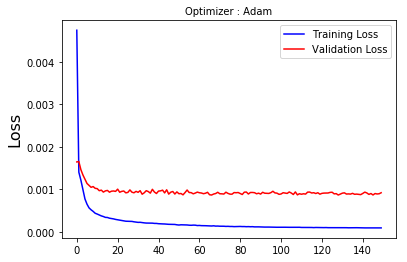

In [47]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')